# User satisfaction analytics

In [1]:
#import python library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pickle
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go  
from IPython.display import Image
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import os, sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from Graphical_view import *
from data_display import *
import DB_Connection as db

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
user_data = pd.read_csv('../data/user_engagement.csv')
#user_data.drop("Unnamed: 0", axis=1, inplace= True)
user_data.head()

,MSISDN/Number,sessions,time_duration,Total UL and DL,cluster
0,33601001722.00,1,116720140.00,878690574.00,2
1,33601001754.00,1,181230963.00,156859643.00,1
2,33601002511.00,1,134969374.00,595966483.00,1
3,33601007832.00,1,49878024.00,422320698.00,1
4,33601008617.00,2,37104453.00,1457410944.00,0


#### Based on the engagement analysis + the experience analysis you conducted above ,
**Write a python program to assign:**
- Engagement score to each user
- Consider the engagement score as the Euclidean distance between the user data point & the less engaged cluster (use the first clustering for this) (Euclidean Distance) experience score to each user.
- Consider the experience score as the Euclidean distance between the user data point & the worst experience’s cluster.

**Experience**

In [4]:
# Loading experience model
with open('../models/user_exp.pkl', 'rb') as f:
    experience_model = pickle.load(f)
experience_model


KMeans(n_clusters=3, random_state=42)

In [5]:
with open('../models/user_eng.pkl', 'rb') as f:
    engagement_model = pickle.load(f)
engagement_model

KMeans(n_clusters=4, random_state=42)

In [6]:
# Get the centroids of the engagement model
engagement_centroids = engagement_model.cluster_centers_

# Get the centroids of the experience model
experience_centroids = experience_model.cluster_centers_

print("Engagement Centroids:")
print(engagement_centroids)

print("Experience Centroids:")
print(experience_centroids)


Engagement Centroids:
[[ 0.63678936  0.0951328   0.65207691]
 [-0.53353916 -0.23018298 -0.70794432]
 [-0.75162169 -0.39499126  0.18616444]
 [ 0.61543294  0.4299151  -0.05464261]]
Experience Centroids:
[[-0.60696816 -0.72430188 -0.06593063]
 [-0.01951251  0.85066625 -0.12716368]
 [ 0.70508456 -0.60587742 -0.04246862]]


In [7]:
# Select the centroids for less engaged and worst experience clusters
less_engaged_centroid = engagement_centroids[0]  # Assuming 0 is the less engaged cluster
worst_experience_centroid = experience_centroids[0]  # Assuming 0 is the worst experience cluster

n_components = len(less_engaged_centroid)  # Ensure consistency with clustering

# Fit PCA on the relevant features (excluding User ID)
pca = PCA(n_components=n_components)
user_points = pca.fit_transform(user_data.iloc[:, 2:].to_numpy())  

# Compute engagement scores
engagement_scores = np.linalg.norm(user_points - less_engaged_centroid, axis=1)

# Compute experience scores
experience_scores = np.linalg.norm(user_points - worst_experience_centroid, axis=1)

# Add scores to the DataFrame
user_data['Engagement_score'] = engagement_scores
user_data['Experience_score'] = experience_scores

print(user_data.head(5))

   MSISDN/Number  sessions  time_duration  Total UL and DL  cluster  \
0 33601001722.00         1   116720140.00     878690574.00        2   
1 33601001754.00         1   181230963.00     156859643.00        1   
2 33601002511.00         1   134969374.00     595966483.00        1   
3 33601007832.00         1    49878024.00     422320698.00        1   
4 33601008617.00         2    37104453.00    1457410944.00        0   

   Engagement_score  Experience_score  
0      189536346.69      189536347.55  
1      535782388.51      535782387.54  
2       96255251.17       96255250.01  
3      286038386.20      286038384.86  
4      773674582.53      773674583.41  


* Consider the average of both engagement & experience scores as  the satisfaction score & report the top 10 satisfied customer 

In [8]:
user_data["Satisfaction_score"] = (user_data["Engagement_score"] + user_data["Experience_score"])/2
top_satisfied_users = user_data.sort_values(by="Satisfaction_score", ascending=False)

In [9]:
top_satisfied_users.head(10)

,MSISDN/Number,sessions,time_duration,Total UL and DL,cluster,Engagement_score,Experience_score,Satisfaction_score
13123,33625779332.00,17,18553763486.00,8499620722.00,3,19994777529.90,19994777531.29,19994777530.59
6404,33614892860.00,17,9966905758.00,8846226494.00,3,12764724464.30,12764724465.79,12764724465.04
92584,33760536639.00,15,9279442000.00,8514773963.00,3,12025498525.10,12025498526.59,12025498525.84
13467,33626320676.00,18,8791936680.00,7971167261.00,3,11302017189.32,11302017190.81,11302017190.06
64883,33667163239.00,13,8744922020.00,5618394054.00,3,9909879323.16,9909879324.60,9909879323.88
76077,33675877202.00,15,4865953827.00,7891110608.00,3,8608523074.35,8608523075.80,8608523075.07
92239,33760413819.00,12,5321673794.00,7132370514.00,3,8262338243.19,8262338244.67,8262338243.93
36909,33659725664.00,16,4035436251.00,7705862783.00,3,8020241266.08,8020241267.51,8020241266.80
62804,33666464084.00,11,4536763706.00,7308500938.00,3,7940920583.38,7940920584.84,7940920584.11
56951,33664693736.00,9,6288735771.00,5682007334.00,3,7913983702.42,7913983703.91,7913983703.16


In [ ]:

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_satisfied_users['MSISDN/Number'].astype(str), top_satisfied_users['Satisfaction_score'], color='skyblue')

# Labels and Title
plt.xlabel('User ID (MSISDN/Number)', fontsize=12)
plt.ylabel('Satisfaction Score', fontsize=12)
plt.title('Top 10 Satisfied Customers', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

* **Build a regression model of your choice to predict the satisfaction score of a customer**

In [11]:
# Step 1: Prepare data
features = user_data[['Engagement_score', 'Experience_score']]  # Independent variables
target = user_data['Satisfaction_score']  # Target variable

In [12]:
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


**I shoose RandomForestRegressor.** because:
- It robust and handles non-linear relationsships well.
- provides feature importance, allowing you to understand which features contribute most to the prediction.


In [ ]:
# Step 3: Initialize and train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:

# Step 4: Make predictions
y_pred = model.predict(X_test)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")



Mean Squared Error: 98047732244819.69
R² Score: 1.00


- The MSE is **98,047,732,244,819.69**, which represents the average squared difference between the predicted satisfaction scores and the actual satisfaction scores.
- A high MSE indicates that the model's predictions deviate significantly from the actual values, but in this case, it might be due to the scale of the scores. Satisfaction scores derived from the engagement and experience scores are likely large numbers, causing the MSE to appear inflated.

- The R² score is 1.00, which indicates that the model explains 100% of the variance in the satisfaction score. This is an excellent result, showing that the model fits the data perfectly.
- However, such a perfect R² score might suggest overfitting, especially if the test set is small or highly correlated with the training set.

In [ ]:
# Optional: Feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
print(importance_df)

            Feature  Importance
0  Engagement_score        0.50
1  Experience_score        0.50


- Engagement Score and Experience Score each have an importance value of 0.50, meaning both features contribute equally to predicting the satisfaction score.

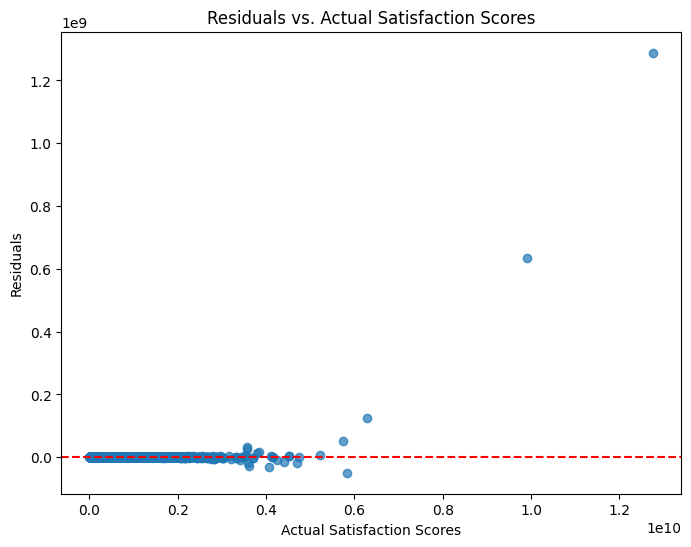

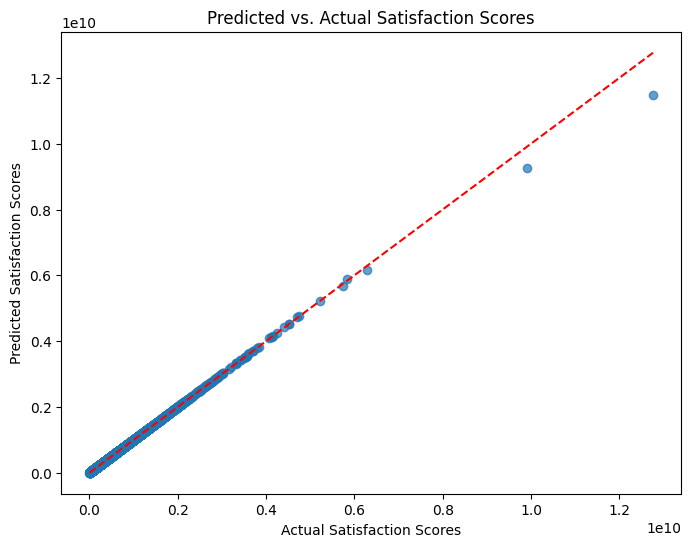

In [ ]:
# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Actual Satisfaction Scores')
plt.xlabel('Actual Satisfaction Scores')
plt.ylabel('Residuals')
plt.show()

# Predicted vs. Actual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicted vs. Actual Satisfaction Scores')
plt.xlabel('Actual Satisfaction Scores')
plt.ylabel('Predicted Satisfaction Scores')
plt.show()

In [17]:
# before adding another cluster, let's remove the previous cluster
user_data.drop("cluster", axis=1, inplace=True)

* **Run a k-means (k=2) on the engagement & the experience score.** 

In [ ]:
scores = user_data[['Engagement_score', 'Experience_score']].to_numpy()

# Run k-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(scores)

# Add cluster labels to the user data
user_data['Cluster'] = kmeans.labels_

# Extract cluster centers
cluster_centers = kmeans.cluster_centers_

user_data[['Engagement_score', 'Experience_score', 'Cluster']].tail(10), cluster_centers

(        Engagement_score  Experience_score  Cluster
 106461      850832371.74      850832372.86        1
 106462       66121273.70       66121272.21        1
 106463       21504117.27       21504118.70        1
 106464      483596285.36      483596284.35        1
 106465      408193117.42      408193118.61        1
 106466      139688454.06      139688453.18        1
 106467      211286309.65      211286308.59        1
 106468      863210479.65      863210480.00        1
 106469      142837094.24      142837094.34        1
 106470      910071835.42      910071835.63        0,
 array([[1.49347963e+09, 1.49347963e+09],
        [3.03536077e+08, 3.03536077e+08]]))

- **Aggregate the average satisfaction & experience score per cluster.**

In [ ]:
cluster_averages = user_data.groupby('Cluster')[['Satisfaction_score', 'Experience_score']].mean()

# Display the aggregated results
cluster_averages

,Satisfaction_score,Experience_score
Cluster,,
0,1492051000.42,1492051001.02
1,303453238.19,303453238.00


In [20]:
user_data.head()

,MSISDN/Number,sessions,time_duration,Total UL and DL,Engagement_score,Experience_score,Satisfaction_score,Cluster
0,33601001722.00,1,116720140.00,878690574.00,189536346.69,189536347.55,189536347.12,1
1,33601001754.00,1,181230963.00,156859643.00,535782388.51,535782387.54,535782388.02,1
2,33601002511.00,1,134969374.00,595966483.00,96255251.17,96255250.01,96255250.59,1
3,33601007832.00,1,49878024.00,422320698.00,286038386.20,286038384.86,286038385.53,1
4,33601008617.00,2,37104453.00,1457410944.00,773674582.53,773674583.41,773674582.97,1


In [21]:
table_row = user_data[["MSISDN/Number", "Engagement_score", "Experience_score","Cluster"]]
table_row.head()

,MSISDN/Number,Engagement_score,Experience_score,Cluster
0,33601001722.00,189536346.69,189536347.55,1
1,33601001754.00,535782388.51,535782387.54,1
2,33601002511.00,96255251.17,96255250.01,1
3,33601007832.00,286038386.20,286038384.86,1
4,33601008617.00,773674582.53,773674583.41,1


In [ ]:
db.insert_data_to_db(table_row, "satisfaction_table")

Data has been successfully inserted into the satisfaction_table table.
